In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


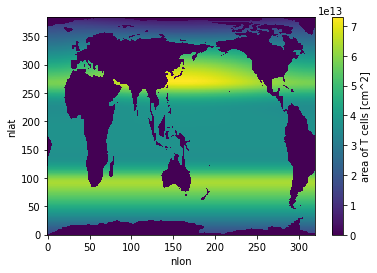

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.32:45638 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/45250/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
varlist = [
    'FG_CO2',
]

experiments = [
    #'piControl',
    'historical',
    'SSP1-2.6',
    'SSP2-4.5',
    'SSP3-7.0',
    'SSP5-8.5',
]

In [6]:
nmols_to_PgCyr = 1e-9 * 86400. * 365. * 12e-15

def global_ann_mean(ds, normalize=True):
    masked_area = ds.TAREA.where(ds.REGION_MASK > 0).fillna(0.)
    compute_vars = [
        v for v in ds 
        if 'time' in ds[v].dims and ('nlat', 'nlon') == ds[v].dims[-2:]
    ]
    
    nyr = int(len(ds.time) / 12)
    
    tb_name = ds.time.attrs['bounds']
    dim = ds[tb_name].dims[-1]
    ds['time'] = ds[tb_name].compute().mean(dim).squeeze()   
    
    weights = ds[tb_name].compute().diff(dim).squeeze()
    weights = weights.groupby('time.year') / weights.groupby('time.year').sum()
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyr))
    
    with xr.set_options(keep_attrs=True):
        
        dso = (ds[compute_vars] * masked_area).sum(['nlat', 'nlon'])    
        if normalize:
            dso = dso[compute_vars] / masked_area.sum(['nlat', 'nlon'])
        else:
            for v in compute_vars:
                if v in ['FG_CO2']:
                    dso[v] = dso[v] * nmols_to_PgCyr
                    dso[v].attrs['units'] = 'Pg C yr$^{-1}$'
                
        return (dso * weights).groupby('time.year').sum(dim='time')


In [7]:
varlist = [
    'FG_CO2',
    'ATM_CO2',
    'SST',
    'HMXL',
    'XMXL'
]
dsets = {}
for experiment in experiments:
    ds_list = []
    for variable in varlist:
        xp_func = xp.persist_ds(cu.read_CESM_var, 
                                name=f'transient-{experiment}-{variable}', 
                                trust_cache=True,)
        
        normalize = variable != 'FG_CO2'
        
        ds_list.append(
            xp_func(
                time_slice=None, 
                variable=variable, 
                postprocess=global_ann_mean,
                postprocess_kwargs=dict(normalize=normalize),
                experiment=experiment,
                mean_dims=['member_id'],
            )
        )

    dsets[experiment] = xr.merge(ds_list)

dsets

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-FG_CO2.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-ATM_CO2.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-SST.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-HMXL.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-XMXL.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-FG_CO2.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-ATM_CO2.nc
assuming cache is corr

{'historical': <xarray.Dataset>
 Dimensions:  (year: 165)
 Coordinates:
   * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
 Data variables:
     FG_CO2   (year) float64 ...
     ATM_CO2  (year) float64 ...
     SST      (year) float64 ...
     HMXL     (year) float64 ...
     XMXL     (year) float64 ...,
 'SSP1-2.6': <xarray.Dataset>
 Dimensions:  (year: 86)
 Coordinates:
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
 Data variables:
     FG_CO2   (year) float64 ...
     ATM_CO2  (year) float64 ...
     SST      (year) float64 ...
     HMXL     (year) float64 ...
     XMXL     (year) float64 ...,
 'SSP2-4.5': <xarray.Dataset>
 Dimensions:  (year: 86)
 Coordinates:
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
 Data variables:
     FG_CO2   (year) float64 ...
     ATM_CO2  (year) float64 ...
     SST      (year) float64 ...
     HMXL     (year) float64 ...
     XMXL     (year) float64 ...

In [ ]:
del client
del cluster

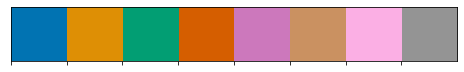

In [8]:
import seaborn as sns

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'PI': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}

In [31]:
variable_labels = dict(
    year='Year',
    FG_CO2='Air-sea CO$_2$ flux [Pg C yr$^{-1}$]',
    photoC_TOT_zint_100m='NPP (z > -100m) [Pg C yr$^{-1}$]',
    photoC_TOT_zint='NPP [Pg C yr$^{-1}$]',
    POC_FLUX_100m='POC flux (100 m) [Pg C yr$^{-1}$]',
    ATM_CO2='Atmospheric CO$_2$ [ppm]',
    SST='Temperature [°C]'
)

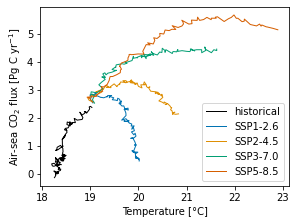

In [85]:
y = 'FG_CO2'
x = 'SST'

nrow = 1
ncol = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for exp in experiments:
    ds = dsets[exp]
    #for member_id in ds.member_id.values:
    #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
    ax.plot(ds[x], ds[y], '-', linewidth=1, color=exp_colors[exp], label=exp)

ax.set_ylabel(variable_labels[y])    
ax.set_xlabel(variable_labels[x])
plt.legend()


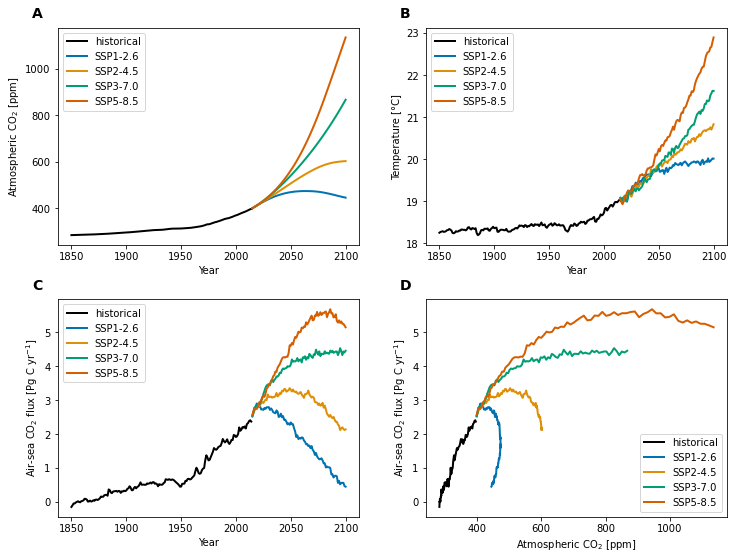

In [82]:
y = 'FG_CO2'
x = 'SST'

nrow = 2
ncol = 2
#fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), constrained_layout=False)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    hspace=0.25,
    wspace=0.22,
)
for i, j in product(range(2), range(2)):
    axs[i, j] = plt.subplot(gs[i, j])



X = [['year', 'year'], ['year', 'ATM_CO2'],]
Y = [['ATM_CO2', 'SST'], ['FG_CO2', 'FG_CO2'],]

for i, j in product(range(2), range(2)):
    ax = axs[i, j]
    x = X[i][j]
    y = Y[i][j]
    for exp in experiments:
        ds = dsets[exp]
        #for member_id in ds.member_id.values:
        #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
        ax.plot(ds[x], ds[y], '-', linewidth=2, color=exp_colors[exp], label=exp)

    ax.set_ylabel(variable_labels[y])    
    ax.legend()
    ax.set_xlabel(variable_labels[x])
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.03, yoff=0.015)   

utils.savefig(f'global-timeseries-FG_CO2.pdf')